### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 9

### Experiments data

In [5]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde']}

In [6]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8]}

In [7]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_6': [0.3865, 0.6135],
                                    'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3702, 0.6298]}

In [8]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping'}

### Loading the data

In [9]:
if (nr_of_experiment != 9 and nr_of_experiment != 4):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [10]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [11]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [12]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [13]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

### Estimation with default kappas

In [14]:
default_MTD = 0.25
default_MTD_th = 0.22

In [15]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(0.827366, 4.1272, 0), (0.827366, 4.1272, 1), (0.827366, 4.1272, 2), (0.827366, 4.1272, 3), (0.827366, 4.1272, 4)]
Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0]
Chunk bounds: [(0.577366, 4.3772)]
Ion currents in chunks: [1.0000000000000013]
Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 1.0
Noise proportion in mixture's spectrum: 0.0
Total explanation: 1.0
Noise proportion in combination of components' spectra: 0.012982665978


In [16]:
estimation_vis['proportions']

[0.2277171004750003,
 0.15221241158600018,
 0.11933757262300015,
 0.17611442219200021,
 0.32461849312400043]

In [17]:
estimation_vis['proportion_of_noise_in_components']

0.012982665978000017

In [18]:
1 - sum(estimation_vis['proportions'])

-1.3322676295501878e-15

In [19]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 12.765225648880005 seconds.


In [20]:
# #MTD = 0.25, MTD_th = 0.22

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0937, 0.9063

# #2: 'Pinene', 'Limonene'
# 0.5240, 0.4760

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7511, 0.1059, 0.0809, 0.0621

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1341, 0.1960, 0.1397

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3931, 0.6069

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8428, 0.1572

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3762, 0.6238

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1333, 0.1967, 0.1395

### Components without scaling

In [21]:
xlims_lower = [5.05, 0.5, 4.4, 3.55, 3.55, 1.55, 7.2, 9.1, 3.55]
xlims_upper = [5.55, 2, 7.8, 4.05, 4.05, 2.4, 7.5, 10.1, 4.05]
ylims_lower = [-0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005]
ylims_upper = [0.0012, 0.0025, 0.00016, 0.0016, 0.0011, 0.0016, 0.0026, 0.0014, 0.0016]

In [22]:
ppm = np.array(mix.confs)[:,0]

<IPython.core.display.Javascript object>


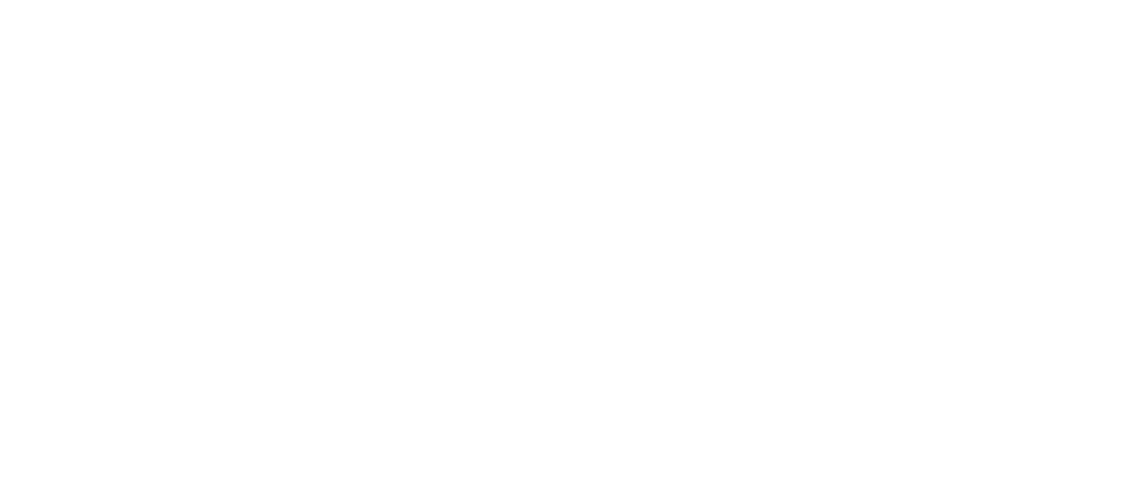

<IPython.core.display.Javascript object>


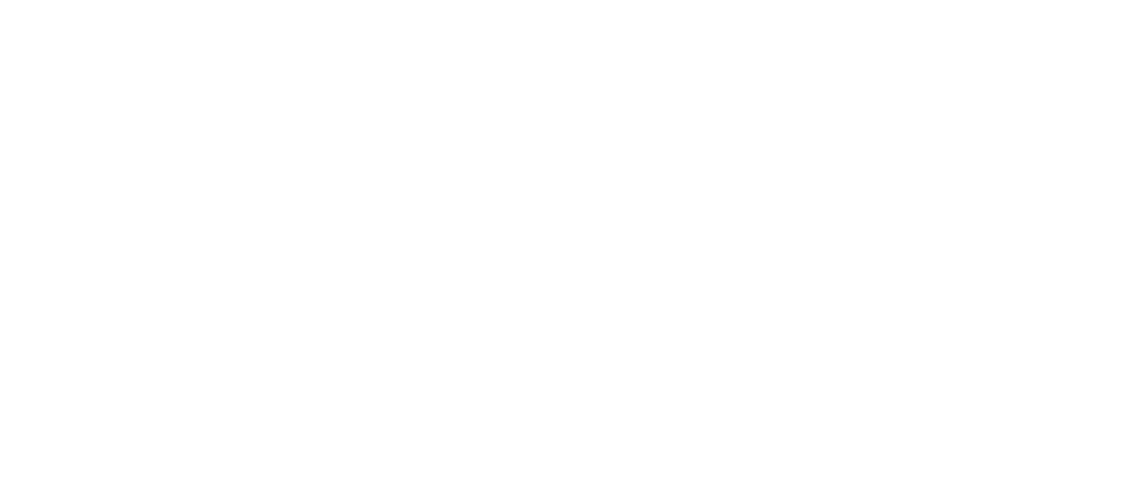

<IPython.core.display.Javascript object>


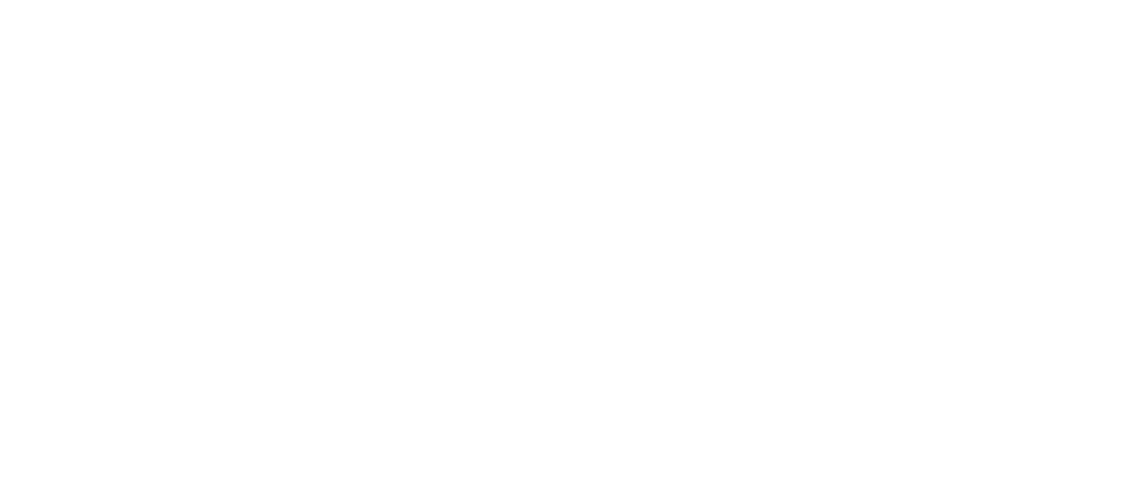

<IPython.core.display.Javascript object>


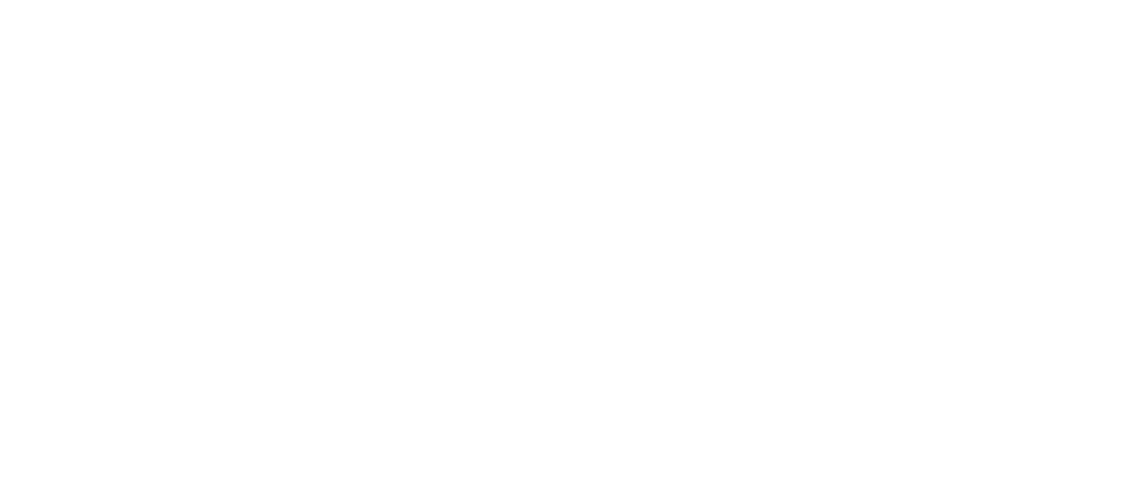

<IPython.core.display.Javascript object>


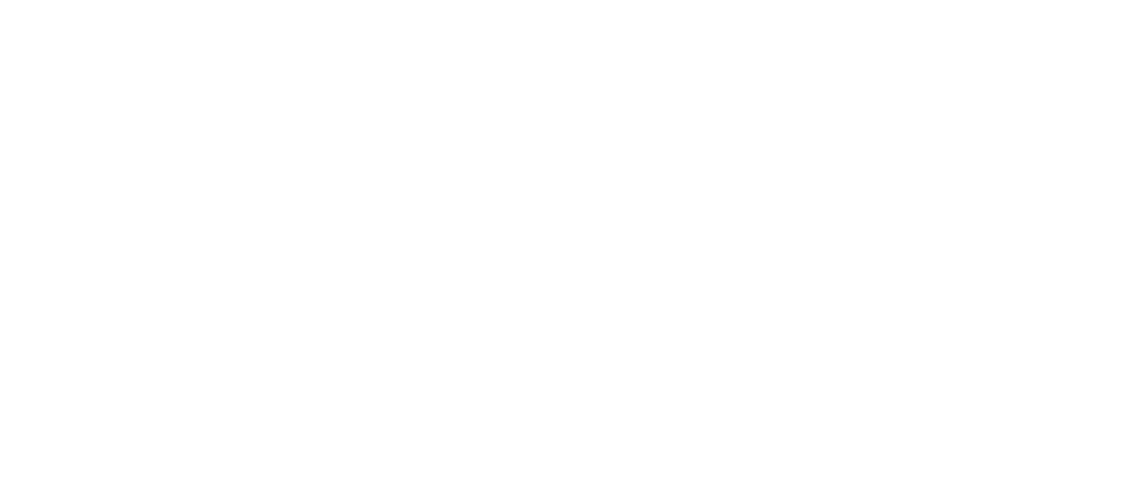

In [23]:
colors = ['blue', 'orange', 'green', 'red', 'pink']

for i, spectrum in enumerate(spectra):
    fig, ax = plt.subplots()
    #fig.set_size_inches(10, 7, forward=True)
    fig.set_size_inches(9, 4, forward=True)

    ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
    #ax.set_ylim(x=ylims_lower[nr_of_experiment-1], ylims_upper[nr_of_experiment-1])
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
    intensity = np.array(spectrum.confs)[:,1]
    ax.plot(ppm, intensity, color=colors[i],
           label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    ax.fill_between(ppm, 0, intensity, color=colors[i], alpha=1.0)
    ax.invert_xaxis()

    ax.legend(prop={'size': 12}, loc='upper left')
    plt.tight_layout()
    plt.show()
#     plt.savefig(os.getcwd()+'/visualisations/experiment'+str(nr_of_experiment)+'/component'+str(i)+'.png', dpi=300)
#     plt.clf()

### Mixture vs linear combination of components (noise removed)

In [24]:
ignore_negative = False

In [25]:
def make_nonnegative(ints):
    res_ints = ints
    for col_nr in range(ints.shape[1]):
        neg = ints[:,col_nr]<0
        res_ints[:,col_nr][neg]=0
    return(res_ints)

#### Removing noise from mix

In [26]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [27]:
mix_without_noise = NMRSpectrum(confs = list(zip(ppm, mix_ints - np.array(estimation_vis['noise']))))
mix_without_noise = np.array(mix_without_noise.confs)[:,1]

In [28]:
if ignore_negative:
    mix_without_noise = make_nonnegative(mix_without_noise.reshape(-1,1))

In [29]:
mix_without_noise = mix_without_noise/sum(mix_without_noise)

In [30]:
thr = -1e-4
print('Is there a lot of negative signal in mixture (intensity below '+str(thr)+')?')
print(sum(mix_without_noise[mix_without_noise<thr]))

Is there a lot of negative signal in mixture (intensity below -0.0001)?
0


#### Removing noise from components

In [31]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [32]:
thr = -1e-4
for i, arr in enumerate(components_ints):
    print('Is there a lot of negative signal in mixture (intensity below '+str(thr)+')?')
    print('Component '+str(i)+':')
    print(sum(arr[arr<thr]))

Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 0:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 1:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 2:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 3:
0
Is there a lot of negative signal in mixture (intensity below -0.0001)?
Component 4:
0


In [33]:
p = estimation_vis['proportions']
p = np.array(p).reshape(len(p),1)

In [34]:
names_components_up_to = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [35]:
components = [comp.reshape(-1,1) for comp in components_ints]
components_no_scaling = np.concatenate(components, axis=1)
components_scaled = components_no_scaling*p[:,0]

In [36]:
proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))
proportions_point_by_point = np.nan_to_num(proportions_point_by_point)
noise_in_ref = np.array(estimation_vis['noise_in_components']).reshape(-1,1)
noise_split_for_components = proportions_point_by_point*noise_in_ref

/tmp/ipykernel_11027/428760648.py:1: RuntimeWarning: invalid value encountered in divide
  proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))


In [37]:
(np.round(components_scaled-noise_split_for_components, decimals=5)>=0).all()

True

In [38]:
X = components_scaled - noise_split_for_components

In [39]:
(np.sum(X[:,:1], axis=1)==X[:,0]).all()

True

In [40]:
if ignore_negative:
    X = make_nonnegative(X)

In [41]:
for i, name in enumerate(names_components_up_to):
    #not_normalized = np.sum(X[:,:(i+1)], axis=1)
    
    globals()[name] = np.sum(X[:,:(i+1)], axis=1)

In [42]:
xlims_lower = [5.05, 0.5, 4.4, 3.55, 3.55, 1.55, 7.2, 9.1, 3.55]
xlims_upper = [5.55, 2, 7.8, 4.05, 4.05, 2.4, 7.5, 10.1, 4.05]
ylims_lower = [-0.00005, -0.00005, -0.000025, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005]
ylims_upper = [0.0055, 0.0035, 0.00016, 0.0016, 0.0011, 0.0016, 0.003, 0.0014, 0.0016]

#### Components added in estimated proportions (noise removed)

<IPython.core.display.Javascript object>


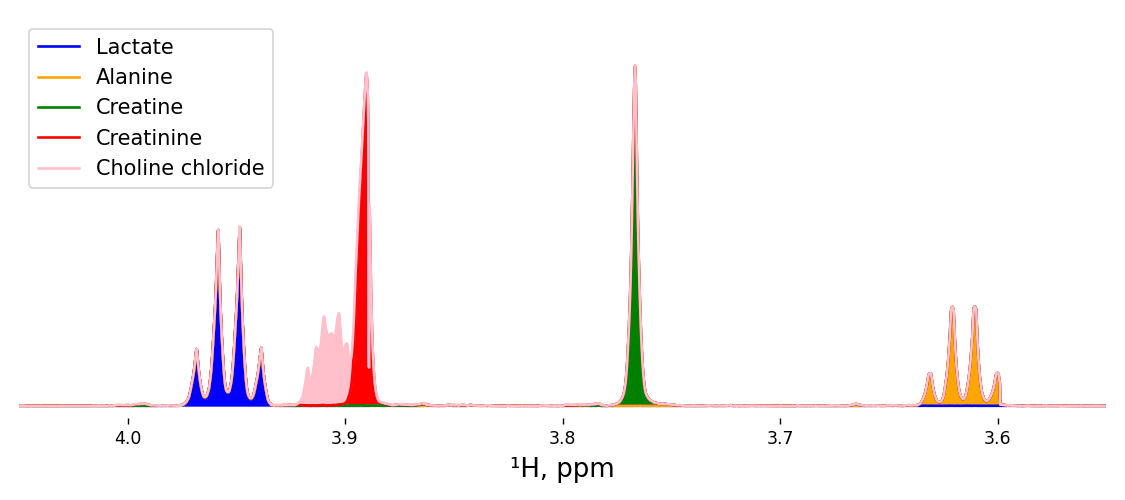

In [43]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
#fig.set_size_inches(10, 7, forward=True)
fig.set_size_inches(9, 4, forward=True)


ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(ylims_lower[nr_of_experiment-1], ylims_upper[nr_of_experiment-1])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
#plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_components_up_to):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], 
            label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)

ax.invert_xaxis()
ax.legend(prop={'size': 12}, loc='upper left')
plt.tight_layout()
#plt.savefig(os.getcwd()+'/visualisations/experiment'+str(nr_of_experiment)+'/all_components.png', dpi=300)

#### Mix without noise

<IPython.core.display.Javascript object>


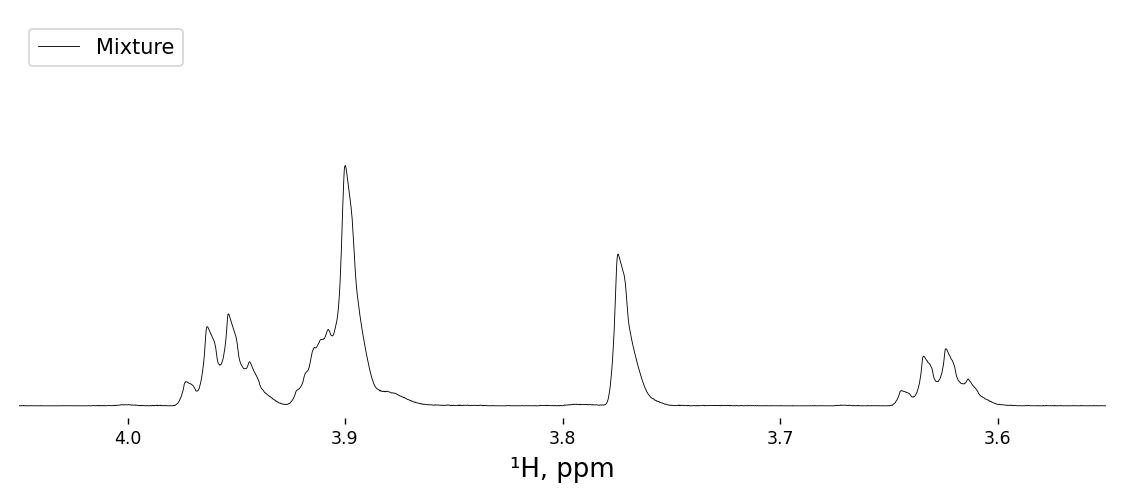

In [44]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
#fig.set_size_inches(10, 7, forward=True)
fig.set_size_inches(9, 4, forward=True)


ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(ylims_lower[nr_of_experiment-1], ylims_upper[nr_of_experiment-1])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
#plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

ax.plot(ppm, mix_without_noise, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.invert_xaxis()

ax.legend(prop={'size': 12}, loc='upper left')
fig.tight_layout()
#fig.savefig(os.getcwd()+'/visualisations/experiment'+str(nr_of_experiment)+'/mixture.png', dpi=300)

#### Components added in estimated proportions (noise removed) + mix without noise

<IPython.core.display.Javascript object>


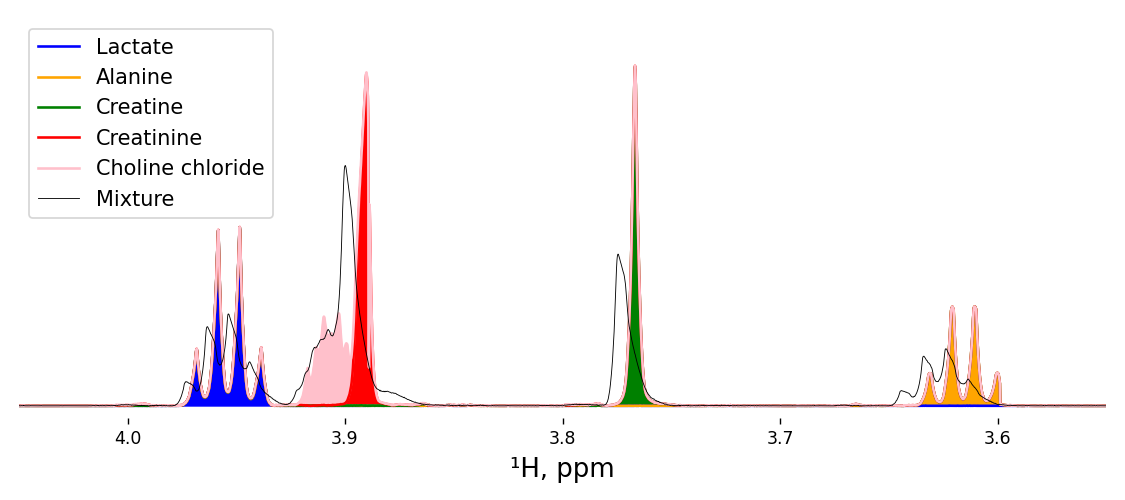

In [45]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
#fig.set_size_inches(10, 7, forward=True)
fig.set_size_inches(9, 4, forward=True)

ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(ylims_lower[nr_of_experiment-1], ylims_upper[nr_of_experiment-1])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
#plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_components_up_to):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], 
            label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_without_noise, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12}, loc='upper left')
ax.invert_xaxis()
plt.tight_layout()
#fig.savefig(os.getcwd()+'/visualisations/experiment'+str(nr_of_experiment)+'/mixture_and_all_components.png', dpi=300)